In [1]:
import tensorflow as tf
import numpy as np
import os
from google.colab import files
import matplotlib.pyplot as plt
import tensorflow_datasets as ds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.datasets as datasets
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape

In [2]:
(X_train, _), (_, _) = datasets.cifar10.load_data() # loading the dataset

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [3]:
print("Dataset shape:", X_train.shape)

Dataset shape: (50000, 32, 32, 3)


In [4]:
X_train = X_train.astype("float32") / 127.5 - 1

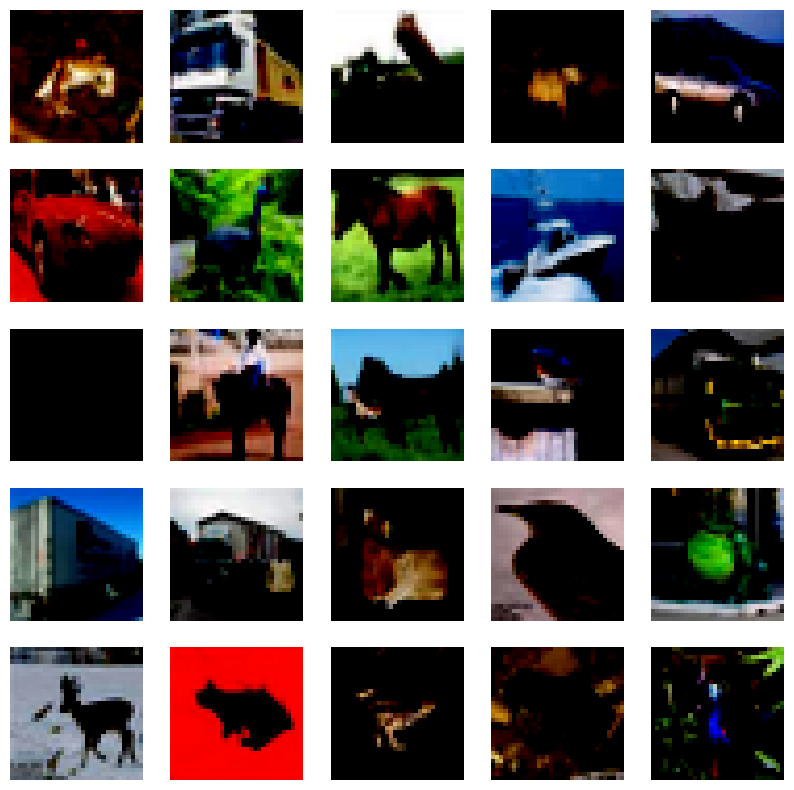

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i])
  plt.axis("off")
plt.show()

In [6]:
print("Min pixel value:", X_train.min())
print("Max pixel value:", X_train.max())

Min pixel value: -1.0
Max pixel value: 1.0


In [7]:
BATCH_SIZE = 256
BUFFER_SIZE = 50000

In [8]:
X_train

array([[[[-0.5372549 , -0.5137255 , -0.5058824 ],
         [-0.6627451 , -0.6392157 , -0.64705884],
         [-0.60784316, -0.62352943, -0.6627451 ],
         ...,
         [ 0.23921573,  0.03529418, -0.15294117],
         [ 0.19215691, -0.01960784, -0.19999999],
         [ 0.16078436, -0.02745098, -0.19215685]],

        [[-0.8745098 , -0.84313726, -0.84313726],
         [-1.        , -1.        , -1.        ],
         [-0.85882354, -0.9372549 , -1.        ],
         ...,
         [-0.03529412, -0.3098039 , -0.5686275 ],
         [-0.06666666, -0.3490196 , -0.60784316],
         [-0.04313725, -0.31764704, -0.5529412 ]],

        [[-0.8039216 , -0.8117647 , -0.8352941 ],
         [-0.8745098 , -0.94509804, -1.        ],
         [-0.6156863 , -0.7882353 , -0.9372549 ],
         ...,
         [-0.0745098 , -0.34117645, -0.60784316],
         [-0.05882353, -0.34117645, -0.60784316],
         [-0.14509803, -0.42745095, -0.67058825]],

        ...,

        [[ 0.6313726 ,  0.33333337, -0

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.01, stddev=0.02)

In [11]:
# Buildng the Generator
def build_generator():
    model = keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding="same", activation="tanh")
    ])

    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │           4,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,733,507 (10.43 MB)

 Trainable params: 2,700,355 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [12]:
# Building the Discriminator
def build_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same", input_shape=(32, 32, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])

    return model


discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 215,425 (841.50 KB)

 Trainable params: 215,169 (840.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [13]:
cross_entropy = keras.losses.BinaryCrossentropy()

In [14]:
# Create the discriminator loss
def discriminator_loss(real_output, fake_output):

  real_loss = cross_entropy(tf.ones_like(real_output), real_output)

  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  return real_loss + fake_loss

In [15]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1 = 0.5)

In [17]:
# Define GAN Model using Subclassing
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator  # Set generator model
        self.discriminator = discriminator  # Set discriminator model

    def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer  # Set generator optimizer
        self.d_optimizer = d_optimizer  # Set discriminator optimizer
        self.g_loss = g_loss  # Set generator loss function
        self.d_loss = d_loss  # Set discriminator loss function

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Generate fake images
        noise = tf.random.normal([batch_size, LATENT_DIM])
        generated_images = self.generator(noise, training=True)

        # Train Discriminator
        with tf.GradientTape() as d_tape:
            real_output = self.discriminator(real_images, training=True)  # Real images
            fake_output = self.discriminator(generated_images, training=True)  # Fake images
            d_loss = self.d_loss(real_output, fake_output)

        # Compute gradients for the discriminator
        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train Generator
        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as g_tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss(fake_output)

        # Compute gradients for the generator
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [18]:
class Callback(keras.callbacks.Callback):
    def __init__(self, num_images=16, latent_dim=100):
        super().__init__()
        self.num_images = num_images
        self.latent_dim = latent_dim
        self.seed = tf.random.normal([num_images, latent_dim])

        if not os.path.exists("generated_images"):
            os.makedirs("generated_images")

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            generated_images = self.model.generator(self.seed, training=False)
            generated_images = ((generated_images + 1) * 127.5).numpy().astype("uint8")

            for i in range(self.num_images):
                img_path = f"generated_images/image_epoch_{epoch}_sample_{i}.png"
                plt.imsave(img_path, generated_images[i])
                print(f"Saved: {img_path}")

            print(f"Epoch {epoch}: Images saved successfully!")

            plt.figure(figsize=(10, 10))
            for i in range(self.num_images):
                plt.subplot(4, 4, i + 1)
                plt.imshow(generated_images[i])
                plt.axis("off")
            plt.show()


In [19]:
EPOCH = 100

In [20]:
gan = GAN(generator=generator, discriminator=discriminator)

gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - d_loss: 2.6210 - g_loss: 0.5266Saved: generated_images/image_epoch_0_sample_0.png
Saved: generated_images/image_epoch_0_sample_1.png
Saved: generated_images/image_epoch_0_sample_2.png
Saved: generated_images/image_epoch_0_sample_3.png
Saved: generated_images/image_epoch_0_sample_4.png
Saved: generated_images/image_epoch_0_sample_5.png
Saved: generated_images/image_epoch_0_sample_6.png
Saved: generated_images/image_epoch_0_sample_7.png
Saved: generated_images/image_epoch_0_sample_8.png
Saved: generated_images/image_epoch_0_sample_9.png
Saved: generated_images/image_epoch_0_sample_10.png
Saved: generated_images/image_epoch_0_sample_11.png
Saved: generated_images/image_epoch_0_sample_12.png
Saved: generated_images/image_epoch_0_sample_13.png
Saved: generated_images/image_epoch_0_sample_14.png
Saved: generated_images/image_epoch_0_sample_15.png
Epoch 0: Images saved successfully!


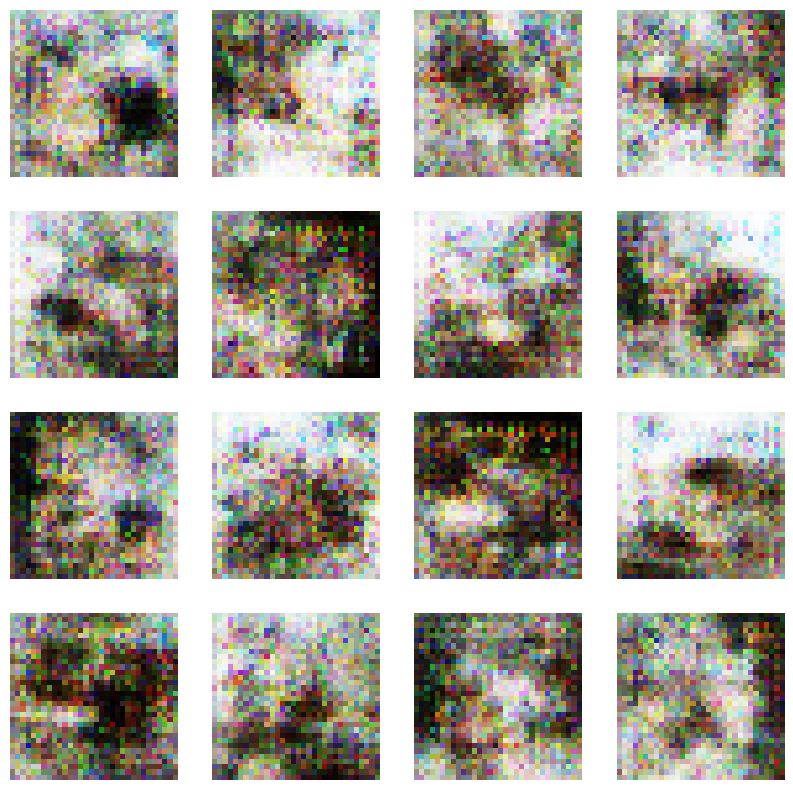

196/196 ━━━━━━━━━━━━━━━━━━━━ 52s 164ms/step - d_loss: 2.6172 - g_loss: 0.5268
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - d_loss: 1.6305 - g_loss: 0.7481
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - d_loss: 1.5722 - g_loss: 0.7006
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - d_loss: 1.4947 - g_loss: 0.7420
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - d_loss: 1.4568 - g_loss: 0.7933
Epoch 6/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 1.4660 - g_loss: 0.8013Saved: generated_images/image_epoch_5_sample_0.png
Saved: generated_images/image_epoch_5_sample_1.png
Saved: generated_images/image_epoch_5_sample_2.png
Saved: generated_images/image_epoch_5_sample_3.png
Saved: generated_images/image_epoch_5_sample_4.png
Saved: generated_images/image_epoch_5_sample_5.png
Saved: generated_images/image_epoch_5_sample_6.png
Saved: generated_images/image_epoch_5_sample_7.png
Saved: generated_images/image_epoch_5_sample_8.png
Saved: generate

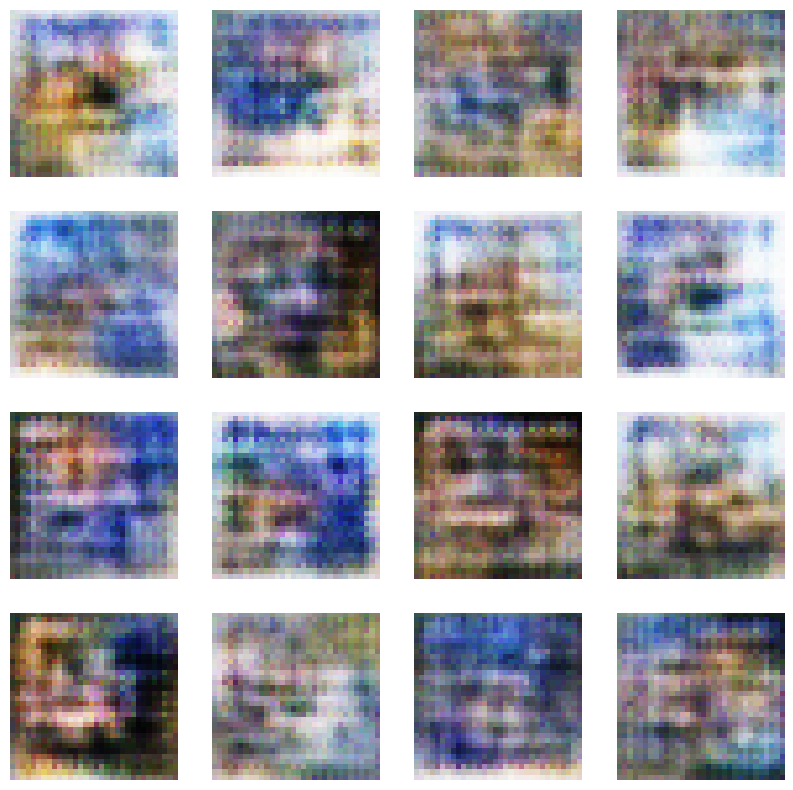

196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - d_loss: 1.4670 - g_loss: 0.8013
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.4553 - g_loss: 0.7659
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.4322 - g_loss: 0.7735
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.4397 - g_loss: 0.7428
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.4346 - g_loss: 0.7391
Epoch 11/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 1.4366 - g_loss: 0.7315Saved: generated_images/image_epoch_10_sample_0.png
Saved: generated_images/image_epoch_10_sample_1.png
Saved: generated_images/image_epoch_10_sample_2.png
Saved: generated_images/image_epoch_10_sample_3.png
Saved: generated_images/image_epoch_10_sample_4.png
Saved: generated_images/image_epoch_10_sample_5.png
Saved: generated_images/image_epoch_10_sample_6.png
Saved: generated_images/image_epoch_10_sample_7.png
Saved: generated_images/image_epoch_10_sample_8.png
Save

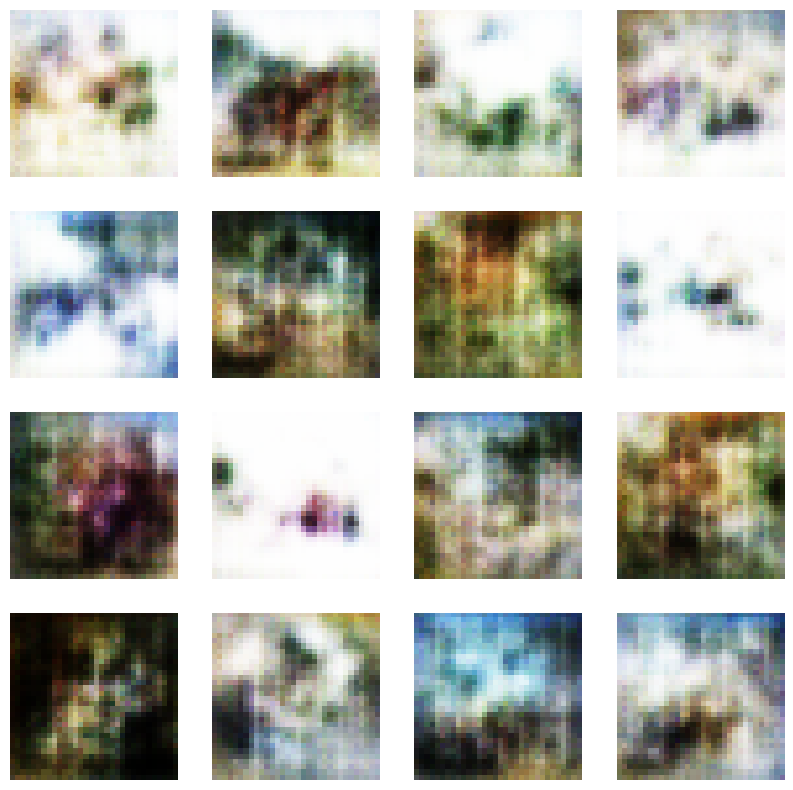

196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - d_loss: 1.4362 - g_loss: 0.7317
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.4302 - g_loss: 0.7275
Epoch 13/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.4217 - g_loss: 0.7198
Epoch 14/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.4186 - g_loss: 0.7290
Epoch 15/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.4183 - g_loss: 0.7251
Epoch 16/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 1.4145 - g_loss: 0.7173Saved: generated_images/image_epoch_15_sample_0.png
Saved: generated_images/image_epoch_15_sample_1.png
Saved: generated_images/image_epoch_15_sample_2.png
Saved: generated_images/image_epoch_15_sample_3.png
Saved: generated_images/image_epoch_15_sample_4.png
Saved: generated_images/image_epoch_15_sample_5.png
Saved: generated_images/image_epoch_15_sample_6.png
Saved: generated_images/image_epoch_15_sample_7.png
Saved: generated_images/image_epoch_15_sample_8.png
S

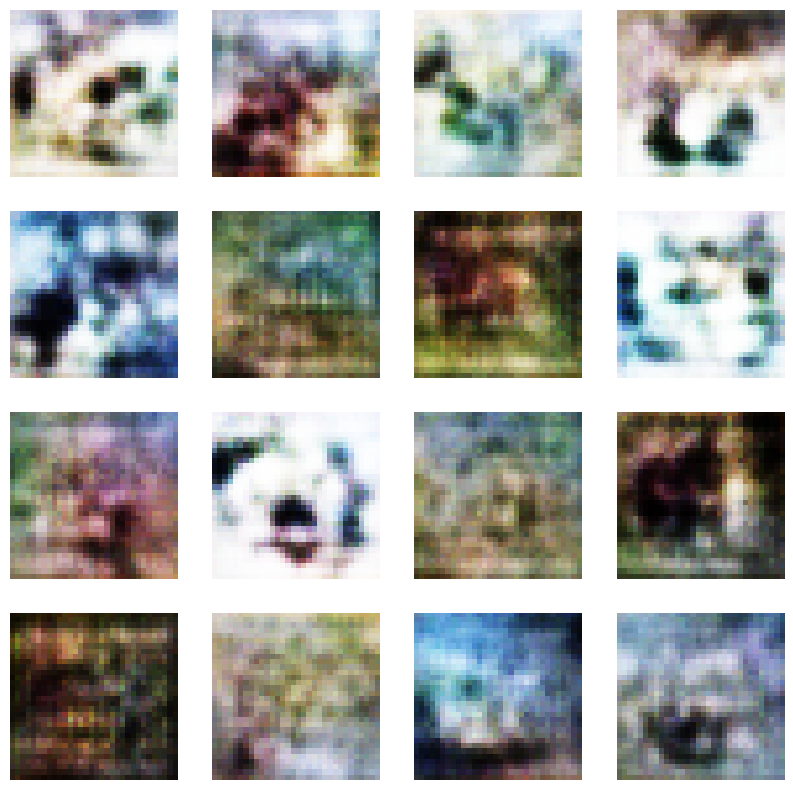

196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - d_loss: 1.4148 - g_loss: 0.7169
Epoch 17/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.4117 - g_loss: 0.7174
Epoch 18/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.4056 - g_loss: 0.7149
Epoch 19/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.3997 - g_loss: 0.7217
Epoch 20/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.3835 - g_loss: 0.7349
Epoch 21/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 1.3618 - g_loss: 0.7765Saved: generated_images/image_epoch_20_sample_0.png
Saved: generated_images/image_epoch_20_sample_1.png
Saved: generated_images/image_epoch_20_sample_2.png
Saved: generated_images/image_epoch_20_sample_3.png
Saved: generated_images/image_epoch_20_sample_4.png
Saved: generated_images/image_epoch_20_sample_5.png
Saved: generated_images/image_epoch_20_sample_6.png
Saved: generated_images/image_epoch_20_sample_7.png
Saved: generated_images/image_epoch_20_sample_8.png
S

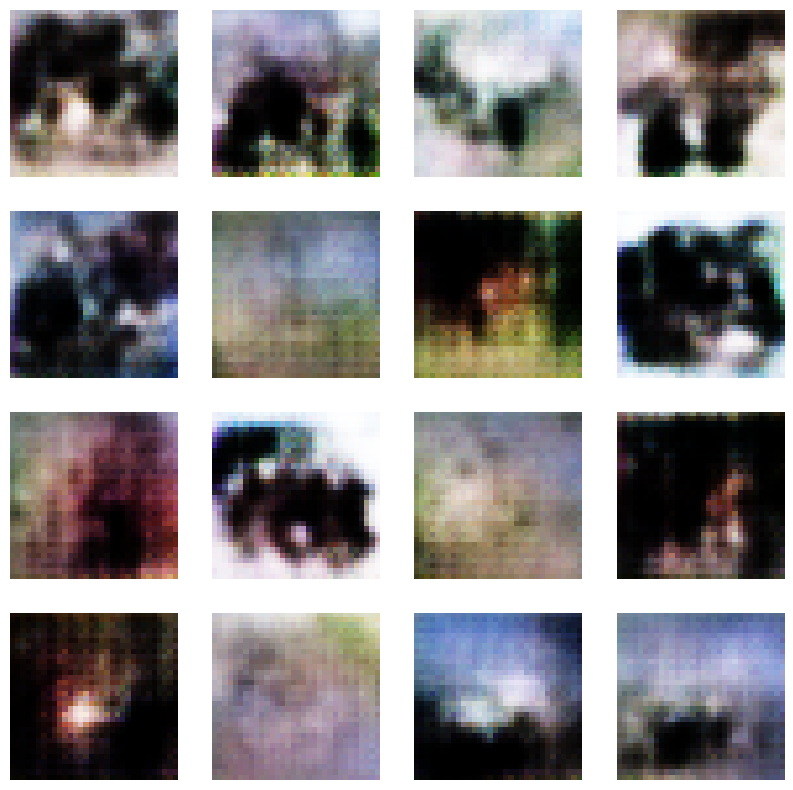

196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - d_loss: 1.3618 - g_loss: 0.7765
Epoch 22/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.3249 - g_loss: 0.8414
Epoch 23/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.1715 - g_loss: 1.0410
Epoch 24/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2001 - g_loss: 1.1048
Epoch 25/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.1867 - g_loss: 1.0899
Epoch 26/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 1.2218 - g_loss: 1.0785Saved: generated_images/image_epoch_25_sample_0.png
Saved: generated_images/image_epoch_25_sample_1.png
Saved: generated_images/image_epoch_25_sample_2.png
Saved: generated_images/image_epoch_25_sample_3.png
Saved: generated_images/image_epoch_25_sample_4.png
Saved: generated_images/image_epoch_25_sample_5.png
Saved: generated_images/image_epoch_25_sample_6.png
Saved: generated_images/image_epoch_25_sample_7.png
Saved: generated_images/image_epoch_25_sample_8.png
S

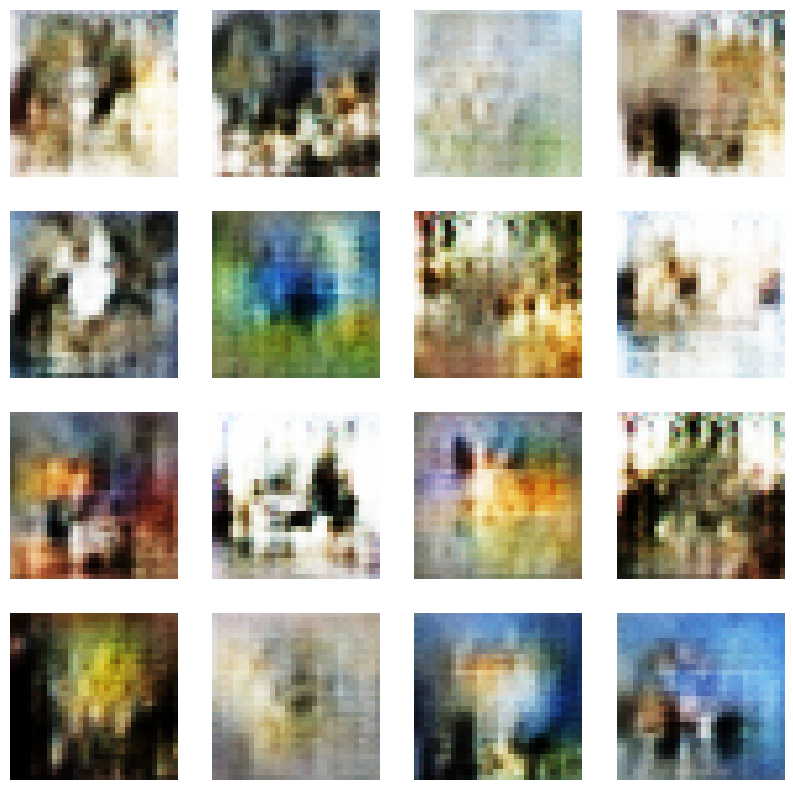

196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - d_loss: 1.2239 - g_loss: 1.0779
Epoch 27/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - d_loss: 1.2097 - g_loss: 1.0666
Epoch 28/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2381 - g_loss: 1.0650
Epoch 29/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - d_loss: 1.2201 - g_loss: 1.0236
Epoch 30/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - d_loss: 1.2053 - g_loss: 1.0531
Epoch 31/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 1.1851 - g_loss: 1.0983Saved: generated_images/image_epoch_30_sample_0.png
Saved: generated_images/image_epoch_30_sample_1.png
Saved: generated_images/image_epoch_30_sample_2.png
Saved: generated_images/image_epoch_30_sample_3.png
Saved: generated_images/image_epoch_30_sample_4.png
Saved: generated_images/image_epoch_30_sample_5.png
Saved: generated_images/image_epoch_30_sample_6.png
Saved: generated_images/image_epoch_30_sample_7.png
Saved: generated_images/image_epoch_30_sample_8.png
S

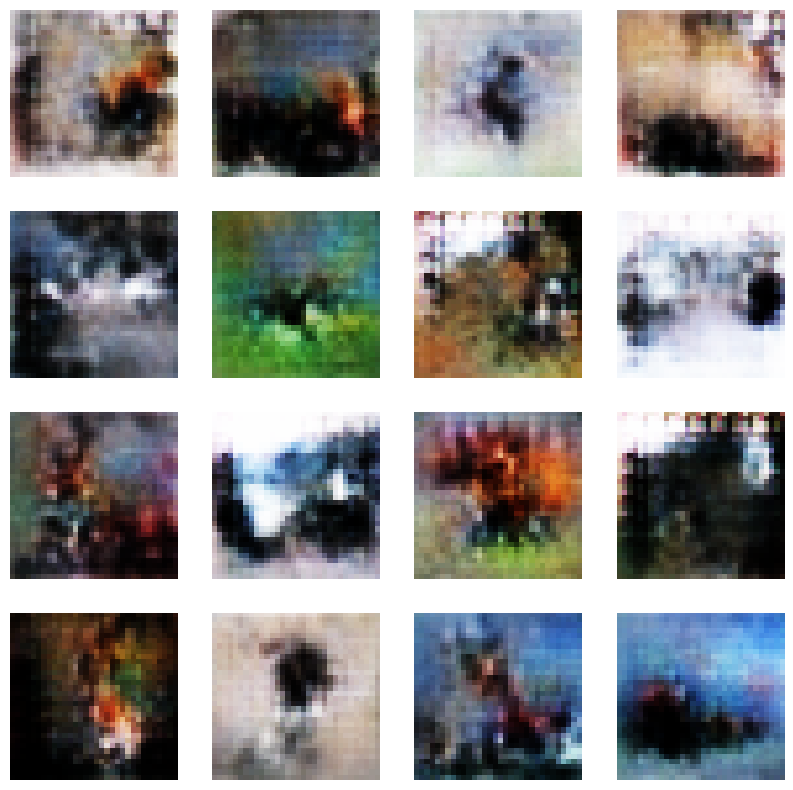

196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/step - d_loss: 1.1850 - g_loss: 1.1005
Epoch 32/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - d_loss: 1.1556 - g_loss: 1.0937
Epoch 33/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - d_loss: 1.1542 - g_loss: 1.1595
Epoch 34/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - d_loss: 1.1293 - g_loss: 1.1282
Epoch 35/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.1240 - g_loss: 1.1709
Epoch 36/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 1.1164 - g_loss: 1.1807Saved: generated_images/image_epoch_35_sample_0.png
Saved: generated_images/image_epoch_35_sample_1.png
Saved: generated_images/image_epoch_35_sample_2.png
Saved: generated_images/image_epoch_35_sample_3.png
Saved: generated_images/image_epoch_35_sample_4.png
Saved: generated_images/image_epoch_35_sample_5.png
Saved: generated_images/image_epoch_35_sample_6.png
Saved: generated_images/image_epoch_35_sample_7.png
Saved: generated_images/image_epoch_35_sample_8.png
S

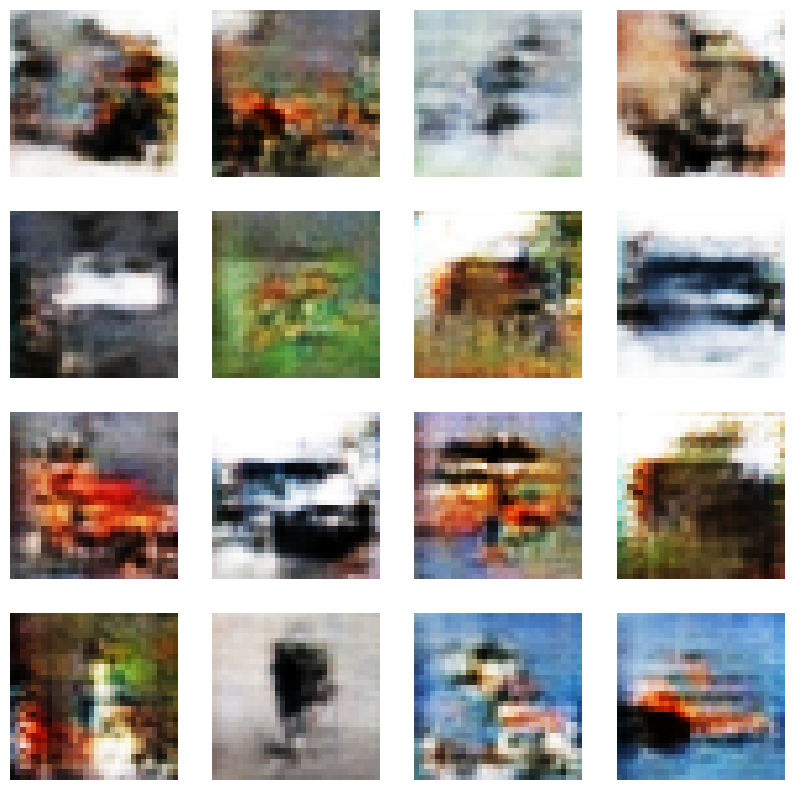

196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - d_loss: 1.1172 - g_loss: 1.1788
Epoch 37/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - d_loss: 1.1226 - g_loss: 1.2392
Epoch 38/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - d_loss: 1.1261 - g_loss: 1.1783
Epoch 39/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - d_loss: 1.1703 - g_loss: 1.0891
Epoch 40/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - d_loss: 1.2011 - g_loss: 1.1205
Epoch 41/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 1.1912 - g_loss: 1.0718Saved: generated_images/image_epoch_40_sample_0.png
Saved: generated_images/image_epoch_40_sample_1.png
Saved: generated_images/image_epoch_40_sample_2.png
Saved: generated_images/image_epoch_40_sample_3.png
Saved: generated_images/image_epoch_40_sample_4.png
Saved: generated_images/image_epoch_40_sample_5.png
Saved: generated_images/image_epoch_40_sample_6.png
Saved: generated_images/image_epoch_40_sample_7.png
Saved: generated_images/image_epoch_40_sample_8.png
S

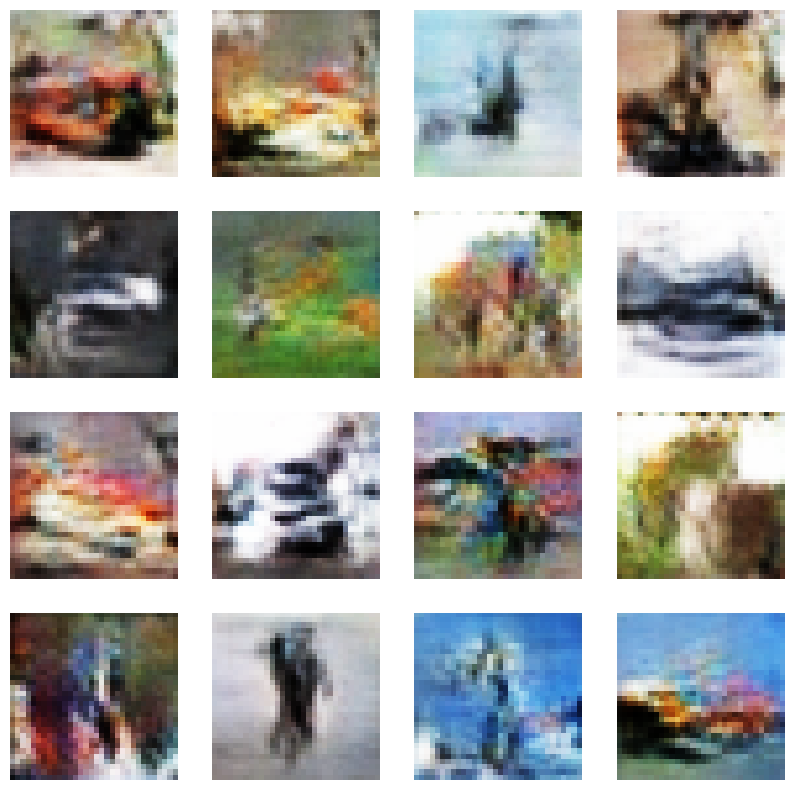

196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - d_loss: 1.1913 - g_loss: 1.0708
Epoch 42/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - d_loss: 1.2188 - g_loss: 1.0316
Epoch 43/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - d_loss: 1.2413 - g_loss: 1.0126
Epoch 44/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - d_loss: 1.2723 - g_loss: 1.0101
Epoch 45/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - d_loss: 1.2773 - g_loss: 0.9864
Epoch 46/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 1.2715 - g_loss: 0.9719Saved: generated_images/image_epoch_45_sample_0.png
Saved: generated_images/image_epoch_45_sample_1.png
Saved: generated_images/image_epoch_45_sample_2.png
Saved: generated_images/image_epoch_45_sample_3.png
Saved: generated_images/image_epoch_45_sample_4.png
Saved: generated_images/image_epoch_45_sample_5.png
Saved: generated_images/image_epoch_45_sample_6.png
Saved: generated_images/image_epoch_45_sample_7.png
Saved: generated_images/image_epoch_45_sample_8.png
S

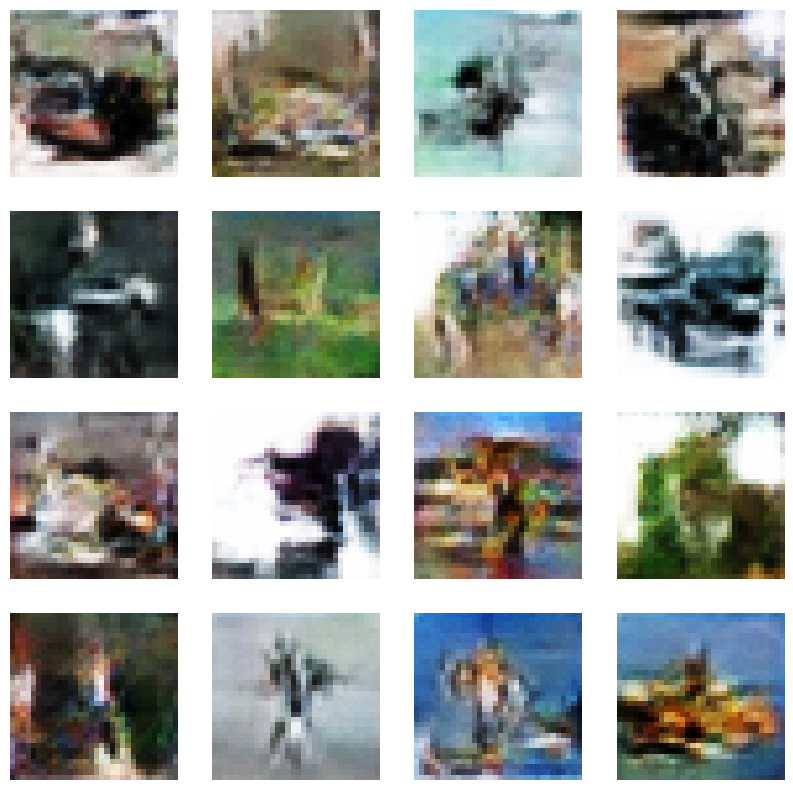

196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - d_loss: 1.2735 - g_loss: 0.9709
Epoch 47/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - d_loss: 1.2905 - g_loss: 0.9572
Epoch 48/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2894 - g_loss: 0.9491
Epoch 49/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - d_loss: 1.2843 - g_loss: 0.9476
Epoch 50/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - d_loss: 1.2964 - g_loss: 0.9826
Epoch 51/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 1.2811 - g_loss: 0.9201Saved: generated_images/image_epoch_50_sample_0.png
Saved: generated_images/image_epoch_50_sample_1.png
Saved: generated_images/image_epoch_50_sample_2.png
Saved: generated_images/image_epoch_50_sample_3.png
Saved: generated_images/image_epoch_50_sample_4.png
Saved: generated_images/image_epoch_50_sample_5.png
Saved: generated_images/image_epoch_50_sample_6.png
Saved: generated_images/image_epoch_50_sample_7.png
Saved: generated_images/image_epoch_50_sample_8.png
S

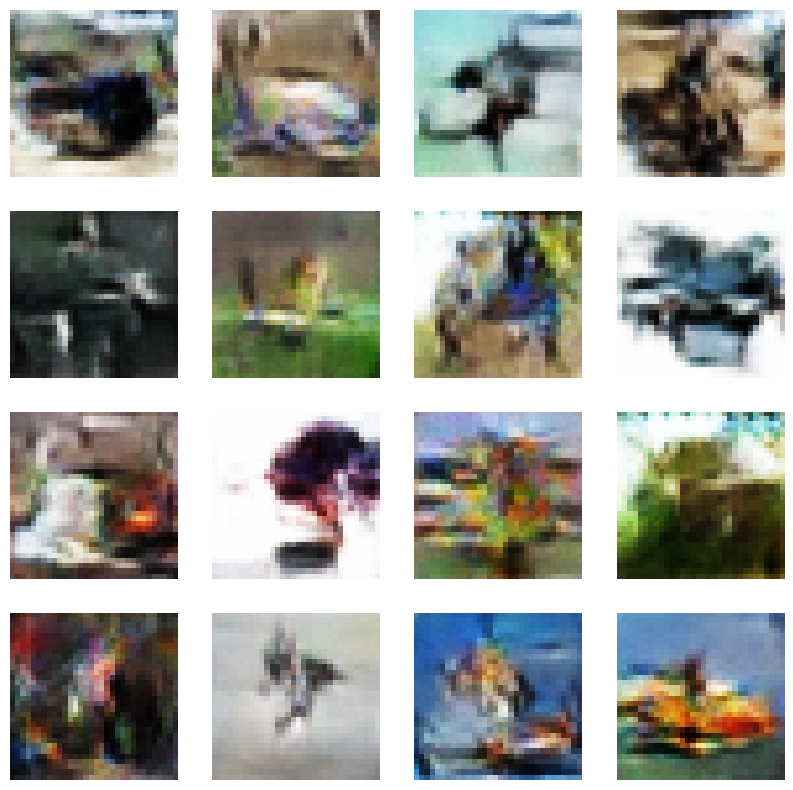

196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - d_loss: 1.2820 - g_loss: 0.9190
Epoch 52/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2920 - g_loss: 0.9398
Epoch 53/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - d_loss: 1.2924 - g_loss: 0.9353
Epoch 54/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - d_loss: 1.2946 - g_loss: 0.9117
Epoch 55/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - d_loss: 1.2888 - g_loss: 0.9290
Epoch 56/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 1.2891 - g_loss: 0.9261Saved: generated_images/image_epoch_55_sample_0.png
Saved: generated_images/image_epoch_55_sample_1.png
Saved: generated_images/image_epoch_55_sample_2.png
Saved: generated_images/image_epoch_55_sample_3.png
Saved: generated_images/image_epoch_55_sample_4.png
Saved: generated_images/image_epoch_55_sample_5.png
Saved: generated_images/image_epoch_55_sample_6.png
Saved: generated_images/image_epoch_55_sample_7.png
Saved: generated_images/image_epoch_55_sample_8.png
S

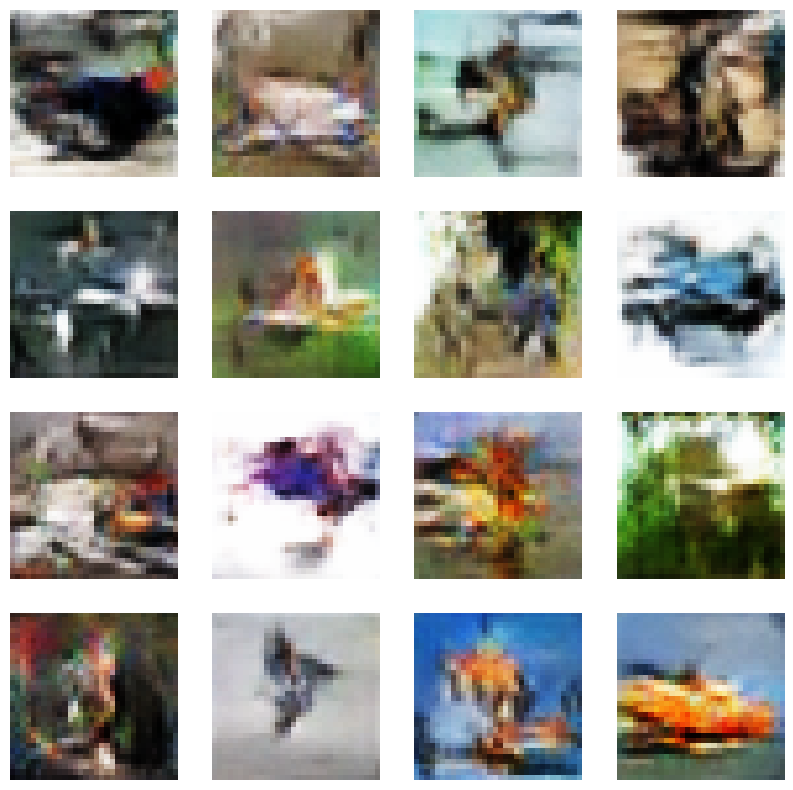

196/196 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - d_loss: 1.2892 - g_loss: 0.9253
Epoch 57/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - d_loss: 1.2812 - g_loss: 0.8881
Epoch 58/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2861 - g_loss: 0.8961
Epoch 59/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2764 - g_loss: 0.9141
Epoch 60/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - d_loss: 1.2753 - g_loss: 0.9071
Epoch 61/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 1.2768 - g_loss: 0.9405Saved: generated_images/image_epoch_60_sample_0.png
Saved: generated_images/image_epoch_60_sample_1.png
Saved: generated_images/image_epoch_60_sample_2.png
Saved: generated_images/image_epoch_60_sample_3.png
Saved: generated_images/image_epoch_60_sample_4.png
Saved: generated_images/image_epoch_60_sample_5.png
Saved: generated_images/image_epoch_60_sample_6.png
Saved: generated_images/image_epoch_60_sample_7.png
Saved: generated_images/image_epoch_60_sample_8.png
S

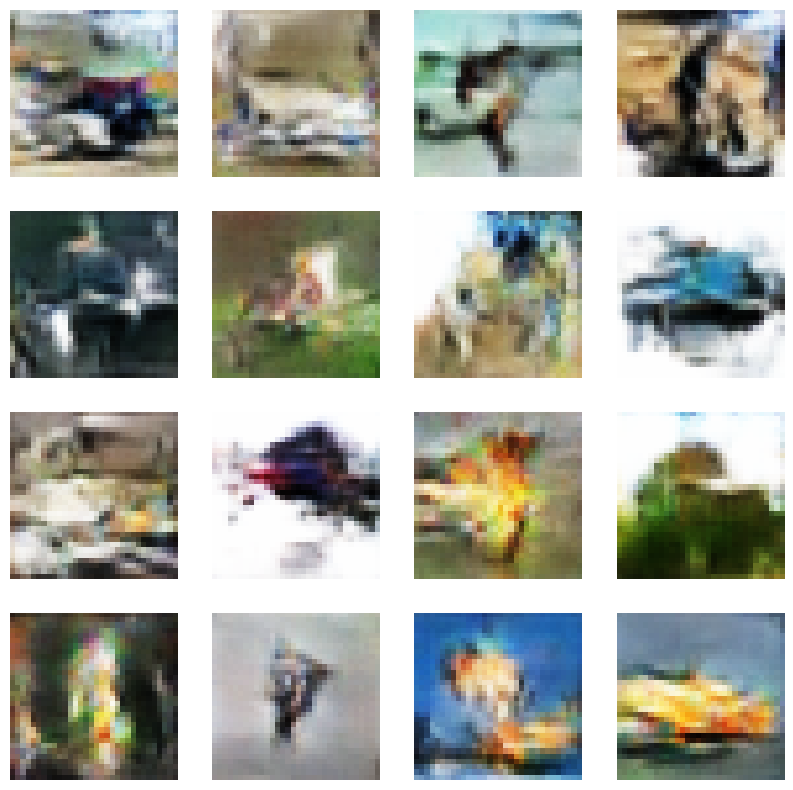

196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - d_loss: 1.2766 - g_loss: 0.9397
Epoch 62/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - d_loss: 1.2716 - g_loss: 0.8943
Epoch 63/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - d_loss: 1.2732 - g_loss: 0.9206
Epoch 64/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - d_loss: 1.2686 - g_loss: 0.9143
Epoch 65/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - d_loss: 1.2642 - g_loss: 0.9340
Epoch 66/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 1.2621 - g_loss: 0.9140Saved: generated_images/image_epoch_65_sample_0.png
Saved: generated_images/image_epoch_65_sample_1.png
Saved: generated_images/image_epoch_65_sample_2.png
Saved: generated_images/image_epoch_65_sample_3.png
Saved: generated_images/image_epoch_65_sample_4.png
Saved: generated_images/image_epoch_65_sample_5.png
Saved: generated_images/image_epoch_65_sample_6.png
Saved: generated_images/image_epoch_65_sample_7.png
Saved: generated_images/image_epoch_65_sample_8.png
S

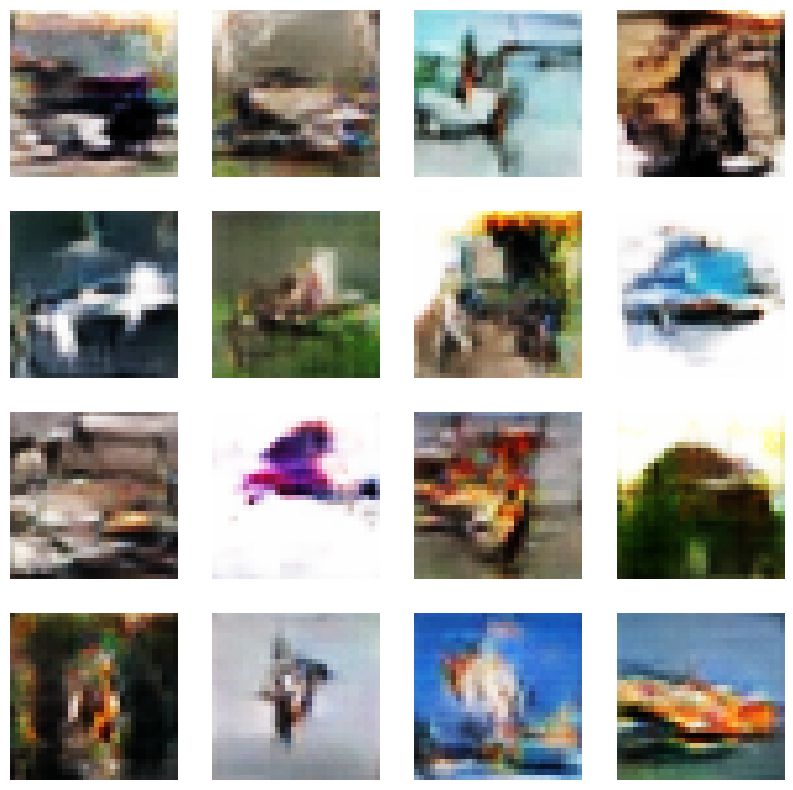

196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - d_loss: 1.2625 - g_loss: 0.9156
Epoch 67/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2762 - g_loss: 0.9110
Epoch 68/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2769 - g_loss: 0.9035
Epoch 69/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - d_loss: 1.2693 - g_loss: 0.9020
Epoch 70/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - d_loss: 1.2777 - g_loss: 0.9357
Epoch 71/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 1.2748 - g_loss: 0.9063Saved: generated_images/image_epoch_70_sample_0.png
Saved: generated_images/image_epoch_70_sample_1.png
Saved: generated_images/image_epoch_70_sample_2.png
Saved: generated_images/image_epoch_70_sample_3.png
Saved: generated_images/image_epoch_70_sample_4.png
Saved: generated_images/image_epoch_70_sample_5.png
Saved: generated_images/image_epoch_70_sample_6.png
Saved: generated_images/image_epoch_70_sample_7.png
Saved: generated_images/image_epoch_70_sample_8.png
S

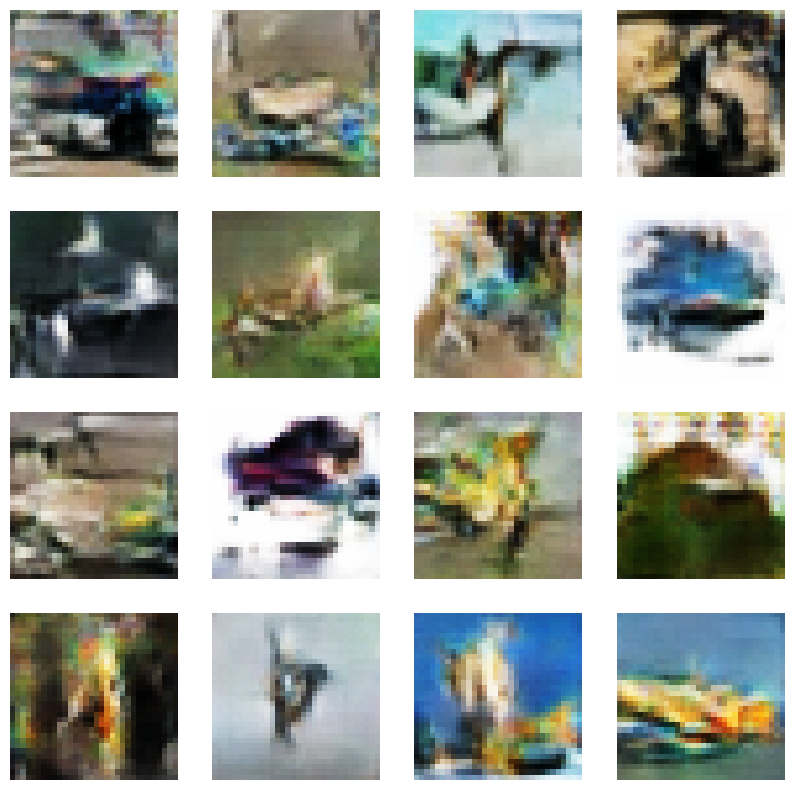

196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - d_loss: 1.2747 - g_loss: 0.9058
Epoch 72/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - d_loss: 1.2757 - g_loss: 0.8992
Epoch 73/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - d_loss: 1.2713 - g_loss: 0.8950
Epoch 74/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - d_loss: 1.2763 - g_loss: 0.8970
Epoch 75/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2815 - g_loss: 0.8896
Epoch 76/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 1.2830 - g_loss: 0.8908Saved: generated_images/image_epoch_75_sample_0.png
Saved: generated_images/image_epoch_75_sample_1.png
Saved: generated_images/image_epoch_75_sample_2.png
Saved: generated_images/image_epoch_75_sample_3.png
Saved: generated_images/image_epoch_75_sample_4.png
Saved: generated_images/image_epoch_75_sample_5.png
Saved: generated_images/image_epoch_75_sample_6.png
Saved: generated_images/image_epoch_75_sample_7.png
Saved: generated_images/image_epoch_75_sample_8.png
S

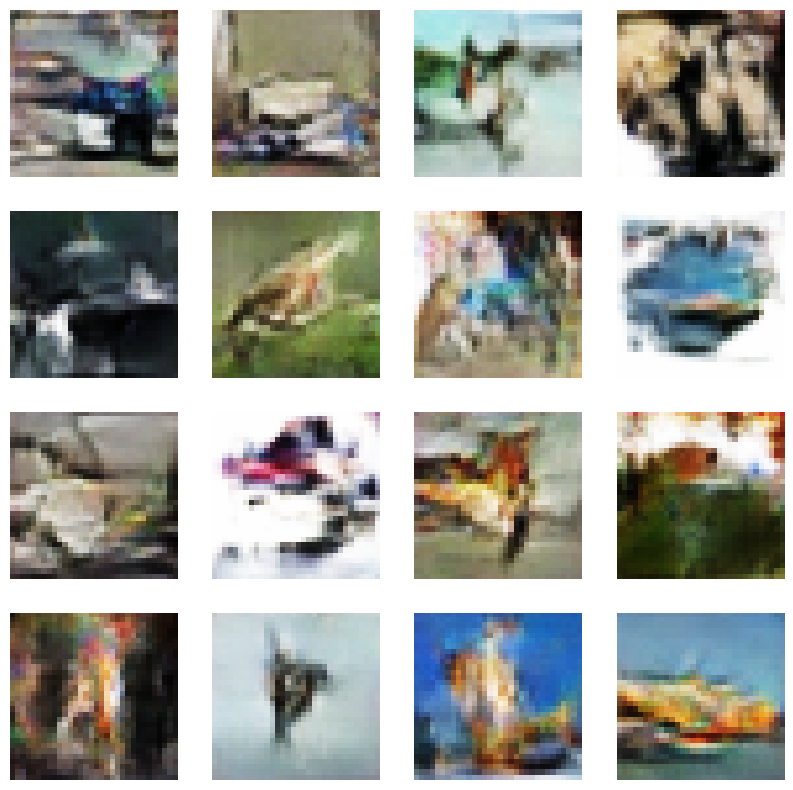

196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - d_loss: 1.2833 - g_loss: 0.8913
Epoch 77/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - d_loss: 1.2890 - g_loss: 0.8906
Epoch 78/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2927 - g_loss: 0.8786
Epoch 79/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2911 - g_loss: 0.8867
Epoch 80/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2956 - g_loss: 0.8833
Epoch 81/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 1.2929 - g_loss: 0.8703Saved: generated_images/image_epoch_80_sample_0.png
Saved: generated_images/image_epoch_80_sample_1.png
Saved: generated_images/image_epoch_80_sample_2.png
Saved: generated_images/image_epoch_80_sample_3.png
Saved: generated_images/image_epoch_80_sample_4.png
Saved: generated_images/image_epoch_80_sample_5.png
Saved: generated_images/image_epoch_80_sample_6.png
Saved: generated_images/image_epoch_80_sample_7.png
Saved: generated_images/image_epoch_80_sample_8.png
S

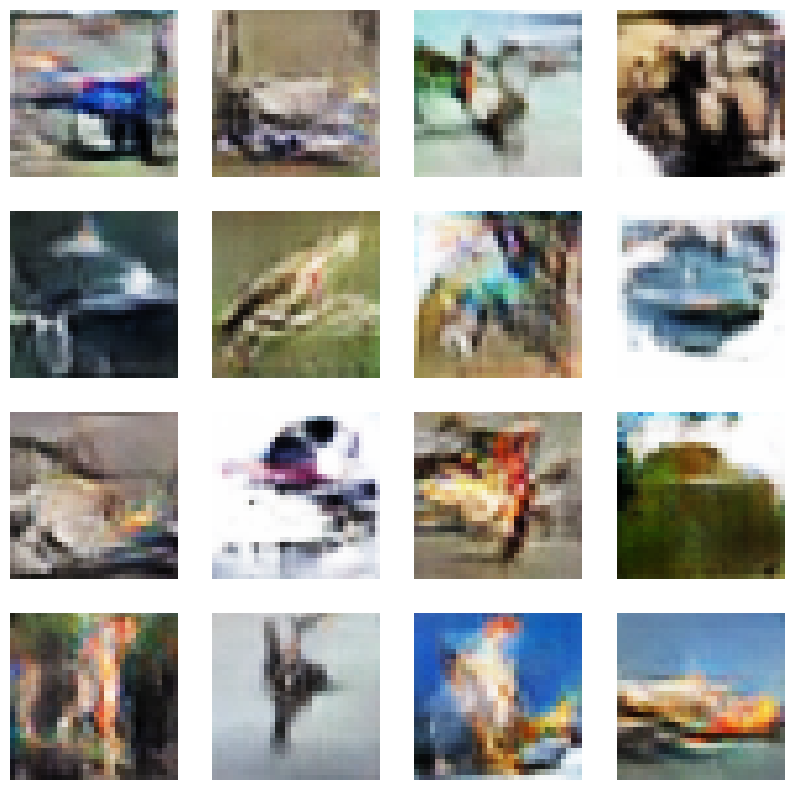

196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - d_loss: 1.2925 - g_loss: 0.8702
Epoch 82/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - d_loss: 1.2989 - g_loss: 0.8737
Epoch 83/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - d_loss: 1.3047 - g_loss: 0.8674
Epoch 84/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - d_loss: 1.3047 - g_loss: 0.8612
Epoch 85/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - d_loss: 1.3043 - g_loss: 0.8500
Epoch 86/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 1.3034 - g_loss: 0.8556Saved: generated_images/image_epoch_85_sample_0.png
Saved: generated_images/image_epoch_85_sample_1.png
Saved: generated_images/image_epoch_85_sample_2.png
Saved: generated_images/image_epoch_85_sample_3.png
Saved: generated_images/image_epoch_85_sample_4.png
Saved: generated_images/image_epoch_85_sample_5.png
Saved: generated_images/image_epoch_85_sample_6.png
Saved: generated_images/image_epoch_85_sample_7.png
Saved: generated_images/image_epoch_85_sample_8.png
S

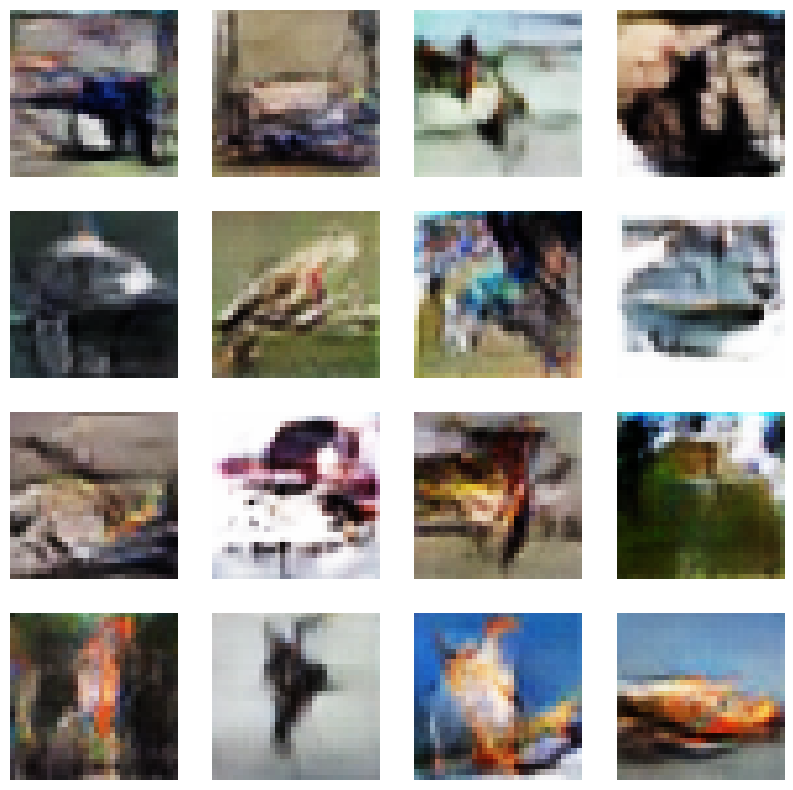

196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - d_loss: 1.3038 - g_loss: 0.8566
Epoch 87/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - d_loss: 1.3020 - g_loss: 0.8534
Epoch 88/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - d_loss: 1.3064 - g_loss: 0.8757
Epoch 89/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - d_loss: 1.2975 - g_loss: 0.8600
Epoch 90/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.3036 - g_loss: 0.8509
Epoch 91/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 1.3083 - g_loss: 0.8579Saved: generated_images/image_epoch_90_sample_0.png
Saved: generated_images/image_epoch_90_sample_1.png
Saved: generated_images/image_epoch_90_sample_2.png
Saved: generated_images/image_epoch_90_sample_3.png
Saved: generated_images/image_epoch_90_sample_4.png
Saved: generated_images/image_epoch_90_sample_5.png
Saved: generated_images/image_epoch_90_sample_6.png
Saved: generated_images/image_epoch_90_sample_7.png
Saved: generated_images/image_epoch_90_sample_8.png
S

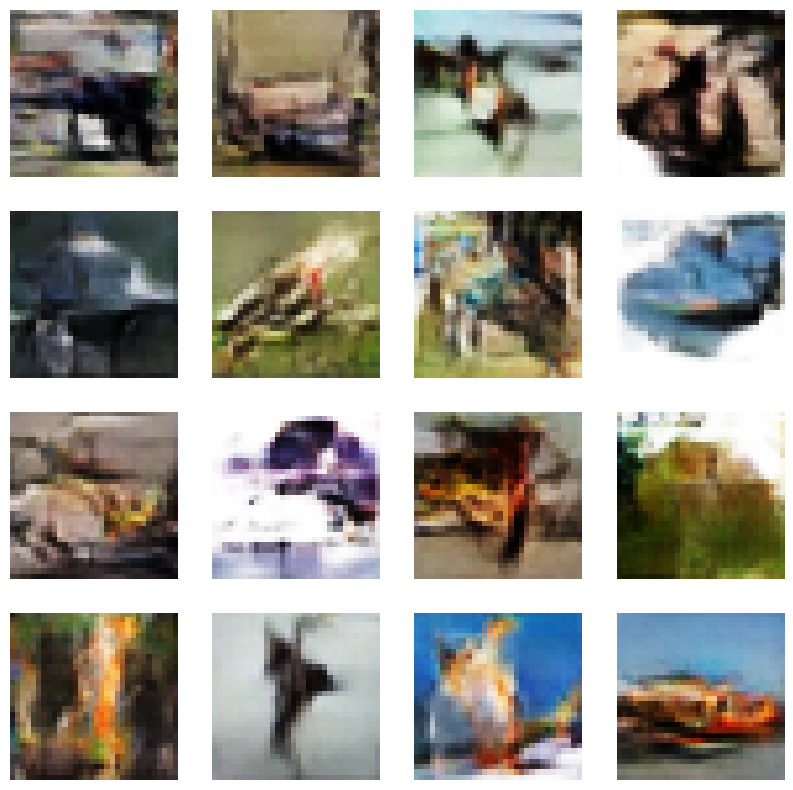

196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - d_loss: 1.3087 - g_loss: 0.8583
Epoch 92/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - d_loss: 1.3060 - g_loss: 0.8491
Epoch 93/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - d_loss: 1.3060 - g_loss: 0.8480
Epoch 94/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - d_loss: 1.3003 - g_loss: 0.8525
Epoch 95/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2995 - g_loss: 0.8582
Epoch 96/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 1.3043 - g_loss: 0.8558Saved: generated_images/image_epoch_95_sample_0.png
Saved: generated_images/image_epoch_95_sample_1.png
Saved: generated_images/image_epoch_95_sample_2.png
Saved: generated_images/image_epoch_95_sample_3.png
Saved: generated_images/image_epoch_95_sample_4.png
Saved: generated_images/image_epoch_95_sample_5.png
Saved: generated_images/image_epoch_95_sample_6.png
Saved: generated_images/image_epoch_95_sample_7.png
Saved: generated_images/image_epoch_95_sample_8.png
S

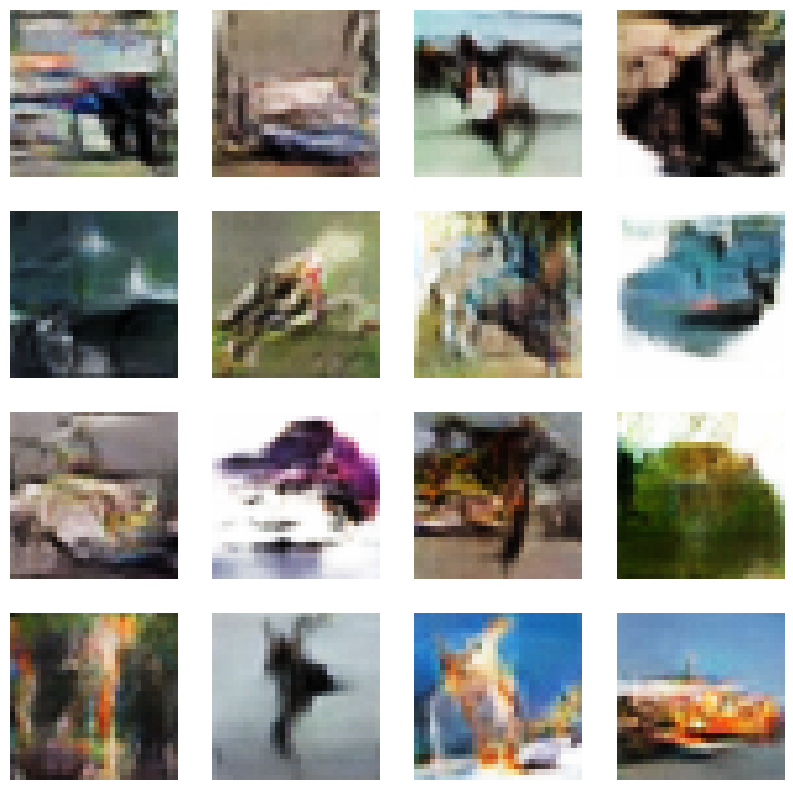

196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - d_loss: 1.3043 - g_loss: 0.8546
Epoch 97/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - d_loss: 1.3065 - g_loss: 0.8483
Epoch 98/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - d_loss: 1.3018 - g_loss: 0.8493
Epoch 99/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - d_loss: 1.3066 - g_loss: 0.8560
Epoch 100/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - d_loss: 1.3024 - g_loss: 0.8506


In [21]:
history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[Callback()])

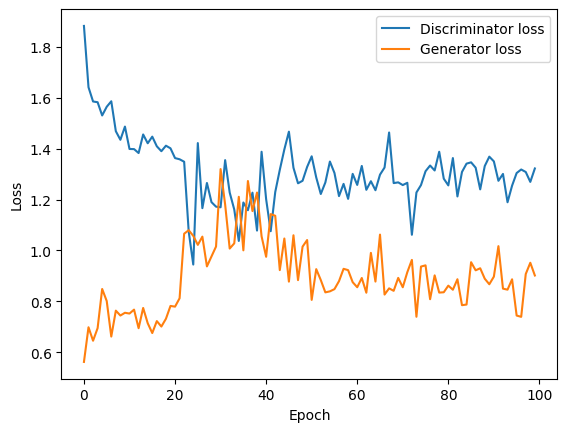

In [22]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5

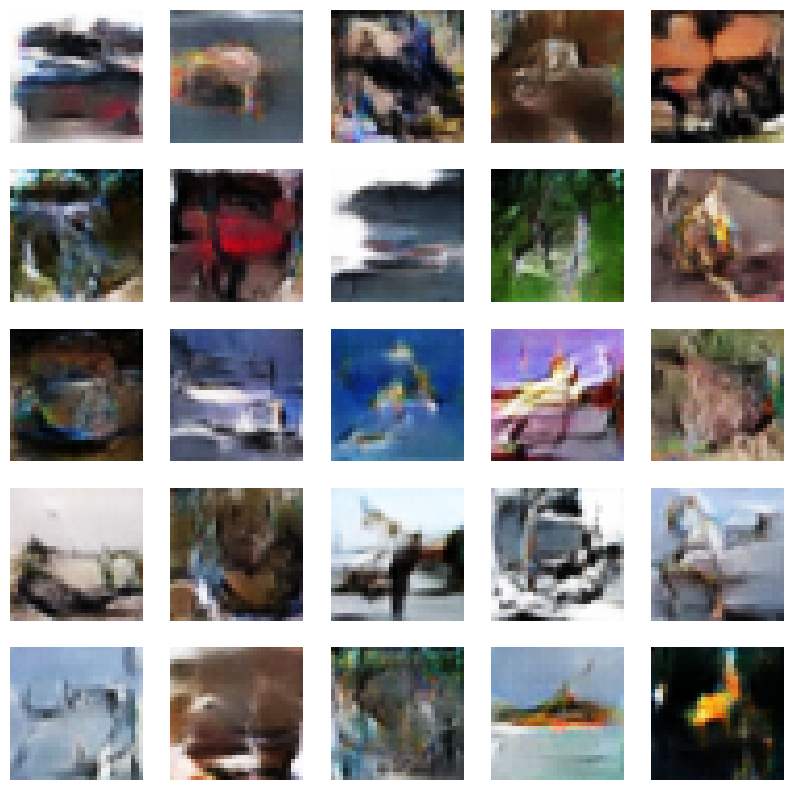

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"))
  plt.axis("off")
plt.show()

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
generator.save("/content/drive/My Drive/fashion_gan_generator.h5")

In [29]:
from google.colab import files

!zip -r generated_images.zip generated_images

files.download("generated_images.zip")


updating: generated_images/ (stored 0%)
updating: generated_images/image_epoch_80_sample_7.png (stored 0%)
updating: generated_images/image_epoch_75_sample_5.png (stored 0%)
updating: generated_images/image_epoch_85_sample_1.png (stored 0%)
updating: generated_images/image_epoch_70_sample_4.png (stored 0%)
updating: generated_images/image_epoch_65_sample_9.png (stored 0%)
updating: generated_images/image_epoch_25_sample_5.png (stored 0%)
updating: generated_images/image_epoch_90_sample_13.png (stored 0%)
updating: generated_images/image_epoch_15_sample_13.png (stored 0%)
updating: generated_images/image_epoch_55_sample_4.png (stored 0%)
updating: generated_images/image_epoch_95_sample_15.png (stored 0%)
updating: generated_images/image_epoch_35_sample_13.png (stored 0%)
updating: generated_images/image_epoch_0_sample_14.png (stored 0%)
updating: generated_images/image_epoch_80_sample_3.png (stored 0%)
updating: generated_images/image_epoch_35_sample_2.png (stored 0%)
updating: generate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>